In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import gensim
from gensim.models.doc2vec import TaggedDocument
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import joblib
from tqdm import tqdm

In [2]:
train = pd.read_csv('train_tweet.csv')
test = pd.read_csv('test_tweets.csv')

train['len'] = train['tweet'].str.len()
test['len'] = test['tweet'].str.len()

In [3]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(train.tweet)

In [4]:
def hashtag_extract(x):
    hashtags = []
    
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [5]:
HT_regular = hashtag_extract(train['tweet'][train['label'] == 0])
HT_negative = hashtag_extract(train['tweet'][train['label'] == 1])

HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

In [6]:
nltk.download('stopwords') #If this dosen't work manually copy the 'nltk_data' folder into C:\\ or /usr 

[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


False

In [7]:
tokenized_tweet = train['tweet'].apply(lambda x: x.split()) 

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            vector_size=200, 
            window=5, 
            min_count=2,
            sg = 1, 
            hs = 0,
            negative = 10, 
            workers= 2, 
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(train['tweet']), epochs=20)

(6109122, 8411580)

In [8]:
tqdm.pandas(desc="progress-bar")

In [9]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(TaggedDocument(s, ["tweet_" + str(i)]))
    return output


labeled_tweets = add_label(tokenized_tweet)
labeled_tweets[:6]

[TaggedDocument(words=['@user', 'when', 'a', 'father', 'is', 'dysfunctional', 'and', 'is', 'so', 'selfish', 'he', 'drags', 'his', 'kids', 'into', 'his', 'dysfunction.', '#run'], tags=['tweet_0']),
 TaggedDocument(words=['@user', '@user', 'thanks', 'for', '#lyft', 'credit', 'i', "can't", 'use', 'cause', 'they', "don't", 'offer', 'wheelchair', 'vans', 'in', 'pdx.', '#disapointed', '#getthanked'], tags=['tweet_1']),
 TaggedDocument(words=['bihday', 'your', 'majesty'], tags=['tweet_2']),
 TaggedDocument(words=['#model', 'i', 'love', 'u', 'take', 'with', 'u', 'all', 'the', 'time', 'in', 'urð\x9f\x93±!!!', 'ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91', 'ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦'], tags=['tweet_3']),
 TaggedDocument(words=['factsguide:', 'society', 'now', '#motivation'], tags=['tweet_4']),
 TaggedDocument(words=['[2/2]', 'huge', 'fan', 'fare', 'and', 'big', 'talking', 'before', 'they', 'leave.', 'chaos', 'and', 'pay', 'disputes', 'when', 'they', 'get', 'there.', '#allshowandnogo'],

In [10]:
train_corpus = []


for i in range(0, 31962):
    review = re.sub('[^a-zA-Z]', ' ', train['tweet'][i])
    review = review.lower()
    review = review.split()

    ps = PorterStemmer()

    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    train_corpus.append(review)


In [11]:

test_corpus = []
for i in range(0, 17197):
    review = re.sub('[^a-zA-Z]', ' ', test['tweet'][i])
    review = review.lower()
    review = review.split()

    ps = PorterStemmer()

    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    test_corpus.append(review)


In [12]:
# Creating a bag of words for train
cv = CountVectorizer(max_features = 2500)
x = cv.fit_transform(train_corpus)
y = train.iloc[:, 1]

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features= 2500, ngram_range=(1,2))    # Unigram and Bigram
x = cv.fit_transform(train_corpus) 
y = train.iloc[:, 1]

In [14]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.25, random_state = 42)

In [16]:
model = DecisionTreeClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

filename = "Completed_model.joblib"
joblib.dump(model, filename)

print("Training Accuracy   :", model.score(x_train, y_train))
print("Validation Accuracy :", model.score(x_valid, y_valid))
print("F1 score            :", f1_score(y_valid, y_pred))


Training Accuracy   : 0.9987902048308372
Validation Accuracy : 0.9244149668376924
F1 score            : 0.5057283142389525


Text(0.5, 1.0, 'Confusion Matrix for Validation results')

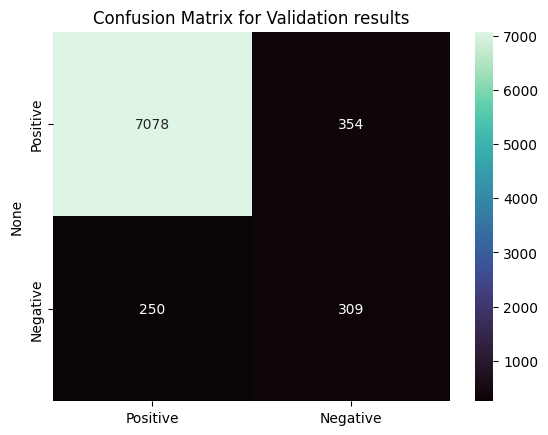

In [17]:
cm = pd.DataFrame(confusion_matrix(y_valid, y_pred), columns= ['Positive', 'Negative'], index= [['Positive', 'Negative']])
ax = plt.axes()
sns.heatmap(cm, annot= True, fmt='g', cmap= 'mako', ax= ax)
ax.set_title("Confusion Matrix for Validation results")

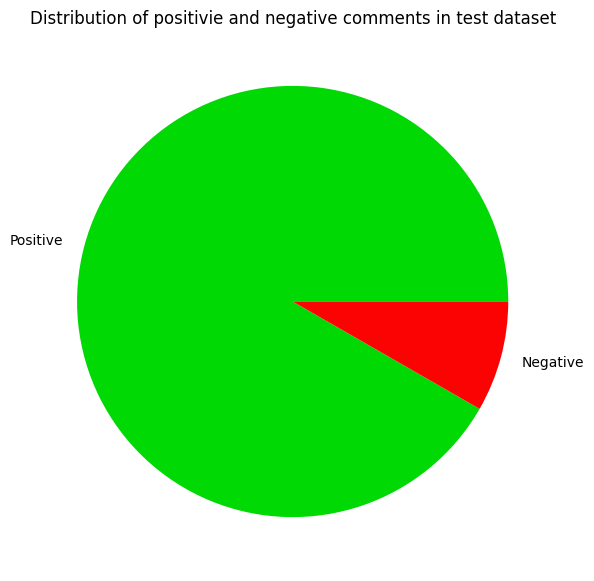

In [18]:
labels = ['Positive', 'Negative']
data = [len(y_pred) - np.sum(y_pred), np.sum(y_pred)]
colors = ['#00d904', '#fc0303',]
fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = labels, colors= colors)
plt.title("Distribution of positivie and negative comments in test dataset")
plt.savefig('pie_chart.png')
plt.show()

In [19]:
for i in range(len(y_pred)):
    twt = train.loc[x_train.shape[0] - 1 + i]['tweet']
    print(f'{twt:<150}', end = "")
    if y_pred[i] == 0:
        print("POSITIVE")
    else:
        print("NEGATIVE")

happy!!! ðð #smile   #hair #model #style #fashion #lips #lipstick #eyesbrown #brunetteâ¦                                                       POSITIVE
seeing everyone's cool and #beautifullyobnoxious hair that people have been posting makes me so   #dyehappy #gooddyeyoung ð                        POSITIVE
hmm - only #superficial #girls fall for such things. you don't need it to be in #love &amp;  ....                                                     NEGATIVE
working on the blog + enjoying a bottle of @user  this evening's of to a splendid sta. â¤ï¸ #blogging #digitalnomad                                 POSITIVE
@user hope to see none of you @user inauguration wait, i won't be watching the  #idiot anyway #mrminority #boycott                                    POSITIVE
the greatest gift i ever had came from god ...... i call him dad ......   #fathers #day  love u dad ...........                                       POSITIVE
low everyone ?? whatz up ??   saturday #gsw ft